In [1]:
###REMOVE_CELL
%config InlineBackend.figure_formats = ['svg']

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

import os
os.environ["FEEDBAX_TQDM"] = "cli"

# Training a pre-built model

Feedbax comes with some [pre-built pairings](/feedbax/api/xabdeef) of models with tasks, provided by the package `feedbax.xabdeef`. Importing one of these is the quickest way to train a model.

For example, let's train a neural network to output forces to push a *point mass*—which has mass but no size, and obeys Newton's laws of motion—between points on a 2D plane. 

First, import the function that provides this pairing.

In [2]:
from feedbax.xabdeef import point_mass_nn_simple_reaches

And construct the pairing:

In [3]:
import jax.random as jr

context = point_mass_nn_simple_reaches(key=jr.PRNGKey(0))

When we build a pairing it's returned as a [`TrainingContext`][feedbax.xabdeef.TrainingContext] object, which we've assigned to `context` in this case. 

!!! NOTE "Random keys"     
    [Feedbax is a JAX library](/feedbax/examples/pytrees), so we'll always explicitly pass a *key* – a `jax.random.PRNGKey` – when our code needs to generate random numbers, such as when initializing model parameters, or generating model noise or task trials. 
    
    This [ensures](/feedbax/examples/pytrees/#random-number-generation) that our results are reproducible, in a stricter and more transparent way than is typical in (say) NumPy or PyTorch.
    
The task provided by this pairing is `SimpleReaches`. Like all task objects in Feedbax, it specifies trials we can use for training our models. In particular, `SimpleReaches` gives the starting location for the effector (in this case, the point mass itself) as well as the goal it should be moved to, both of which are uniformly distributed in a rectangular workspace on the 2D plane. 

## Training the model

We can ask immediately ask the `TrainingContext` to train its model on its task. In return we get a trained model, along with a `TaskTrainerHistory` object that contains information about the training run – including [losses](/feedbax/examples/losses).

In [4]:
model, train_history = context.train(
    n_batches=2000,  # Number of training iterations
    batch_size=250,  # Number of task trials per iteration
    key=jr.PRNGKey(1),
)

Training step compiled in 2.94 seconds.
Validation step compiled in 2.36 seconds.

Training iteration 0:                                        
	training loss: 3.06e+01
	validation loss: 1.31e+01

Training iteration 200:                                                
	training loss: 7.73e-03
	validation loss: 1.56e-03

Training iteration 400:                                                
	training loss: 5.83e-03
	validation loss: 1.06e-03

Training iteration 600:                                                
	training loss: 4.60e-03
	validation loss: 8.79e-04

Training iteration 800:                                                
	training loss: 3.42e-03
	validation loss: 7.86e-04

Training iteration 1000:                                               
	training loss: 2.88e-03
	validation loss: 7.29e-04

Training iteration 1200:                                                
	training loss: 2.64e-03
	validation loss: 6.82e-04

Training iteration 1400:                           

## Interpreting the training history

Feedbax provides some [Matplotlib](https://matplotlib.org/)-based plotting functions. For example, we can visualize the loss history over training using [`loss_history`][feedbax.plot.loss_history].

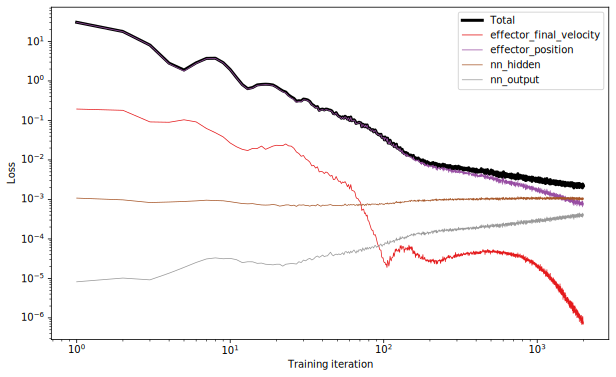

In [5]:
from feedbax import plot

# Losses are stored in `train_history.loss`.
fig, _ = plot.loss_history(train_history)
fig.show()

[Plotly](https://plotly.com/python/)-based counterparts are also included in some cases, for a faster and more interactive experience.

In [6]:
from feedbax.plotly import loss_history

fig = loss_history(train_history)
fig.show()

In [7]:
###REMOVE_CELL
# Output the plotly figure as JSON and embed it in the docs using the mkdocs-plotly plugin
fig.update_layout(width=700, height=400)
fig_json = fig.to_json()

if not isinstance(fig_json, str):
    raise ValueError("No JSON output could be created for figure")
else:
    with open("assets/0_train_simple-plot_loss_history.json", "w") as f:
        f.write(fig_json)

```plotly
{"file_path": "../assets/0_train_simple-plot_loss_history.json"}
```

For the task belonging to this pairing, performance is scored based on four *loss terms*. The model gets a good score on a trial if:

- the *position* of the end-effector (in this case, the point mass itself) is at the goal position, for as much of the trial as possible;
- the *velocity* of the end-effector is zero at the end of the reach;
- the *activity* of the units in the neural network is small;
- the *outputs* of the neural network – in this case, the forces applied to the point mass—are small.

A weighted sum of these terms gives the total loss – the smaller the total, the better the performance. Note that these four terms are not the only ones we could choose. Depending on the context we could add or remove certain terms, or change the weighting on each term based on how important we think it should be to the task at hand. 

By "training the model", we mean altering some part of it—in this case, the strengths of the connections in the neural network – so that its behaviour changes, and it gets a better total score on each batch of trials. In the current example, the technical details of training are taken care of entirely in the background.

Looking at the loss plot above, it's clear that the first term (effector position) dominates the total score for most of the run. This makes sense for a *reaching task* like `SimpleReaches`, since the main thing we're concerned about is that our neural network should learn to move the point mass to the goal position. And it certainly seems like it's learning: over the training history there's a large and consistent decrease in the loss.

The value of the effector final velocity term is smaller, because it is only calculated for a single time step of a reach. However,  it also clearly changes over training. Is that because the network learns to slow down and stop when it reaches the goal position?

## Evaluating the trained model

Let's check whether the network actually learned to push the point mass to the goal and stop there. 

Like all Feedbax tasks, `SimpleReaches` also provides set of trials for the purpose of *validation*. 

<!-- !!! Note "Why was the validation loss so low?" -->

Now we evaluate the model on this set of trials:

In [16]:
task = context.task  # Shorthand, since we'll be referring to this more than once

states = task.eval(model, key=jr.PRNGKey(2))

and plot the resulting states of the model over time:

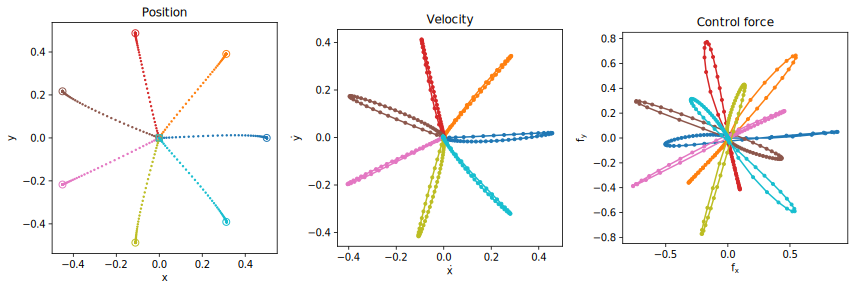

In [9]:
# Use `trial_specs=task.validation_trials` to draw little circles at
# the goal positions specified by the task. Not strictly necessary.
fig, _ = plot.effector_trajectories(states, trial_specs=task.validation_trials)
fig.show()

Each color is a different trial in the validation set, which consists of center-out reaches. The starting position is `(0, 0)` for all seven reaches.

Clearly, the network has learned to move the point mass to the goal. It's also learned to slow down and stop there: the velocities return to zero. 

Is this an improvement over the untrained model? Since `context.model` still refers to the untrained model, we can evaluate it just like we did for the trained model a moment ago.

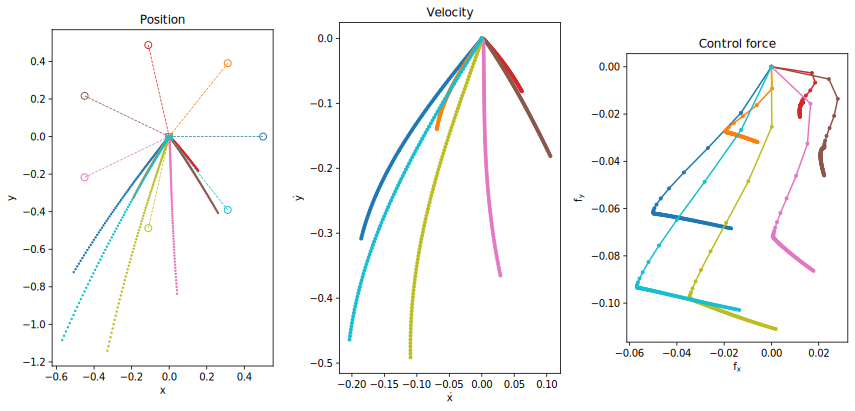

In [10]:
fig, _ = plot.effector_trajectories(
    task.eval(
        context.model,
        key=jr.PRNGKey(2)
    ),
    trial_specs=task.validation_trials,
    # Draw ideal straight paths as dashed lines, based on `trial_specs`.
    straight_guides=True,
)
fig.show()

Obviously, our model could not complete the task before we had trained it to do so!

## Training multiple models simultaneously

It's easy to construct and train multiple replicates of the same pre-built model. Each replicate will have a different random initialization of the neural network weights.

In [11]:
context = point_mass_nn_simple_reaches(n_replicates=5, key=jr.PRNGKey(0))

models, train_history = context.train(
    n_batches=1000,
    batch_size=250,
    key=jr.PRNGKey(1),
)

Training step compiled in 2.90 seconds.
Validation step compiled in 1.59 seconds.

Training iteration 0:                                        
	mean training loss: 2.71e+01
	mean validation loss: 8.88e+00

Training iteration 100:                                                
	mean training loss: 4.78e-02
	mean validation loss: 8.71e-03

Training iteration 200:                                                
	mean training loss: 8.66e-03
	mean validation loss: 1.58e-03

Training iteration 300:                                                
	mean training loss: 6.73e-03
	mean validation loss: 1.22e-03

Training iteration 400:                                                
	mean training loss: 5.41e-03
	mean validation loss: 1.05e-03

Training iteration 500:                                                
	mean training loss: 4.73e-03
	mean validation loss: 9.42e-04

Training iteration 600:                                                
	mean training loss: 4.46e-03
	mean validatio

As we'll see in a [later example](/feedbax/examples/4_vmap#constructing-an-ensemble), all of the model replicates are stored in a single object. 

We can access one of the models using `tree_take`: <a name="states-plot-color"></a>

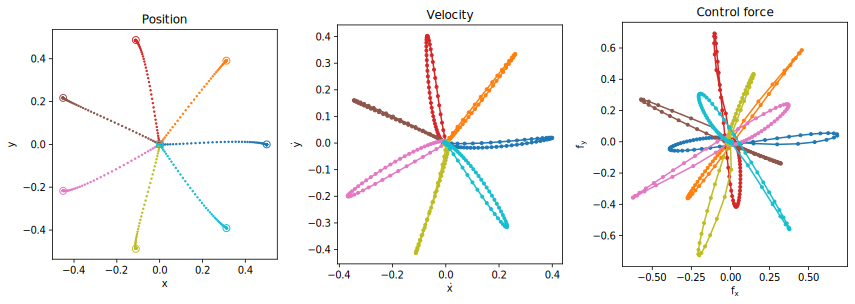

In [12]:
from feedbax import tree_take

model0 = tree_take(models, 0)

states = context.task.eval(model0, key=jr.PRNGKey(2))

fig, _ = plot.effector_trajectories(
    states,
    trial_specs=context.task.validation_trials,
)
fig.show()

## Looking into the network

Similarly to the position and velocity trajectories we plotted above, the history of the activity of the neural network is also stored in `states`. Feedbax provides a couple of functions for visualizing it.

First, we'll use a heatmap to plot the activity of all the hidden units simultaneously, over time, on a single trial. 

Here, there are 7 trials worth of states stored in `states`, so we'll need to select one of them to plot. Like we did earlier when selecting a single model out of an ensemble, we can use `tree_take` to select a single trial's states out of a batch:

In [13]:
states_trial0 = tree_take(states, 0)

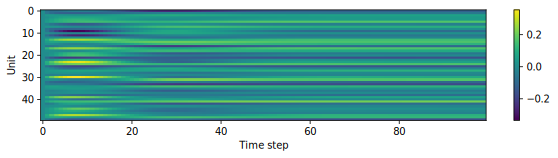

In [14]:
fig, _ = plot.activity_heatmap(states_trial0.net.hidden)
fig.show()

Now, plot the activities of a random sample of individual units, for all the trials in a batch.

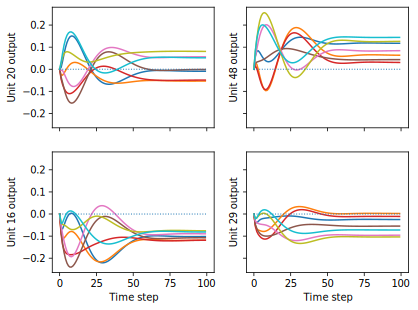

In [15]:
n_units = 4

fig, ax = plot.activity_sample_units(states.net.hidden, n_units, key=jr.PRNGKey(3))
fig.show()

!!! Note 
    Each subplot shows a single unit, and each curve shows the activity of that unit on a single trial. The colormap is the same one used in the [earlier](#states-plot-color) plot of reach trajectories. 
    
    For example, by comparing the two plots, we can see that early in the trial, Unit 20's activity was largest for the trial where the reach was downward and to the right (light blue).

!!! Note 
    The same set of example units will be sampled, as long as the same `key` is passed to `plot_activity_sample_units`, and the network layer has the same number of units in it. 